### Resampling and converting frequencies
#### Pandas asfreq vs. resample
There are two ways to resample data at different frequencies: with the resample() function or with the asfreq() one. The main difference between them is that resample() is a data aggregation function while asfreq() is a data selection function.

* asfreq() simply starts with the first data point and then takes consecutive data points at the new frequency interval
* resample() first splits the data into buckets based on the new frequency and then applies a particular operation to the data in each bucket.This function allows us more flexibility.

#### Downsampling
Let’s look at our example with the financial dataset. Let’s change the frequency to BA which is the end of a business year. We will first do this by combining the resample() with the mean() functions and compare the results with the asfreq() variant.

(9137, 6)


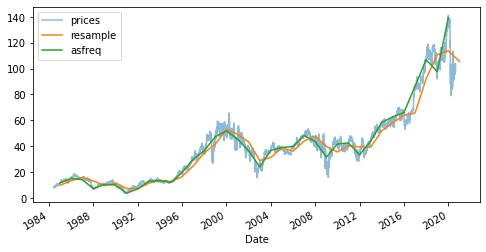

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

# load the data
data = pd.read_csv("c2_financial_data.csv", index_col="Date")

# create the time index
data.index = pd.to_datetime(data.index, format="%d.%m.%y")  # Convert the index
# Let’s take a look at the top entries

# check the few first rows
data.head()
prices = data["Close"]

# Create the figure
plt.figure(figsize=(8, 4))

# Plot the prices
prices.plot(alpha=0.5)

# Downsampling - end of the business year
# Variant 1: using resample()
prices.resample("BA").mean().plot()

# Variant 2: using asfreq()
prices.asfreq("BA").plot()

plt.legend(["prices", "resample", "asfreq"], loc="upper left")
plt.show()

The resample() function reported the average values of the year while the asfreq() function reported the value at the end of the year. Their difference is more visible in the plot for the year 2020. Since the sample ends at 2020-08-28, the asfreq function resulted in no value for the year 2020, and reported the value for the end of 2019.

#### Upsampling
What we performed above is known as downsampling because we decreased the frequency from day to year. We can also upsample and in this case, both resample() and asfreq() have the default of leaving up-sample points empty. With the parameter method we can specify however a strategy of filling in the gap. Two common choices are backward fill and forward fill.

Let’s compare the two methods.

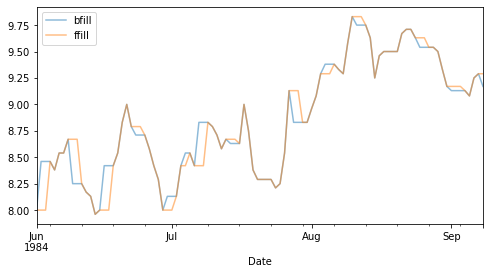

In [3]:
# Create the figure
plt.figure(figsize=(8, 4))

# Upsampling
# "backward fill" - fill missing with the closest value on the right
prices.asfreq("D", method="bfill")[0:100].plot(alpha=0.5)

# "forward fill" - fill missing with the closest value on the left
prices.asfreq("D", method="ffill")[0:100].plot(alpha=0.5)

plt.legend(["bfill", "ffill"], loc="upper left")
plt.show()

To better see the difference, we chose to focus on the first 100 entries only. However, the results are very similar in this case. Note that in this plot the frequency of prices has changed from business days to calendar days. Therefore, weekends and other missing days e.g. holidays are filled in the plot.

Impact of downsampling on distribution of the data
We should note when we change the sampling frequency of the data, the distribution of the resulting sample may also change. Let’s perform the downsampling again using the resample() function.

Here are steps we take in the following:

* we use pct_change() function to calculate the price percentage changes
* we change the frequency of data using resample() function and the list ["B", "W", "M", "Q"]
* we take mean of the resampled data and drop null values generated in the previous steps
* we calculate the skewness and kurtosis of the data

In [4]:
from scipy.stats import skew, kurtosis

# calculate skewness and kurtosis for the resampled data
s, k = [], []
for freq in ["B", "W", "M", "Q"]:
    s.append(skew(prices.pct_change().resample(freq).mean().dropna()))
    k.append(kurtosis(prices.pct_change().resample(freq).mean().dropna()))

**Note** Skewness and kurtosis inform us about the shape of a distribution. Skewness measures the degree of asymmetry around the center. For example, normal distribution is symmetric and has skewness 0. A skewness of smaller or larger than 0 indicates some degree of asymmetry. Kurtosis measures how the tails are stretched on both sides of the distribution. For instance, normal distribution has kurtosis 3, and kurtosis of larger than 3 indicates that the tails of the distribution are further stretched (are fat) compared to the normal distribution.

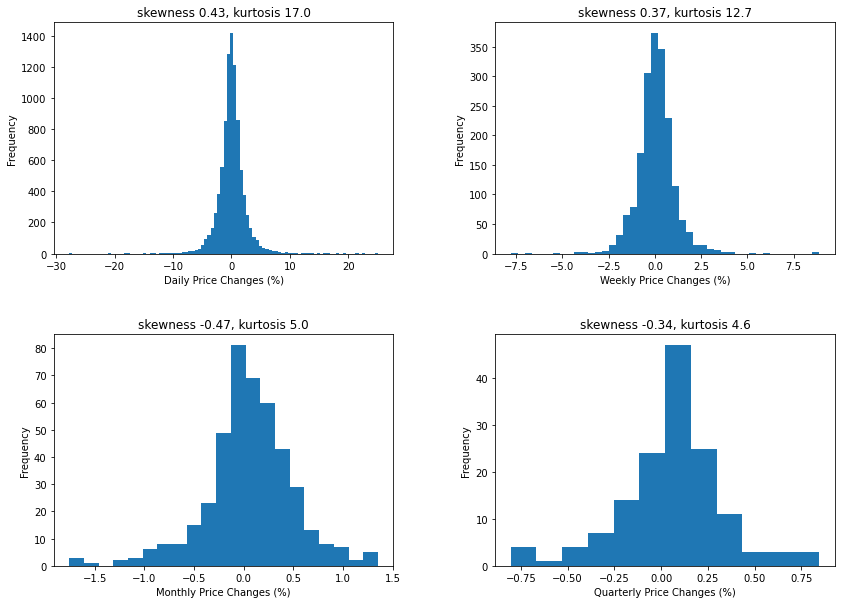

In [5]:
fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(14, 10), gridspec_kw={"hspace": 0.35, "wspace": 0.3}
)

for (ax, resamp, freq, n_bin, i) in zip(
    axes.flatten(),
    ["B", "W", "M", "Q"],  # resampling frequency
    ["Daily", "Weekly", "Monthly", "Quarterly"],  # x-axis labels
    [96, 44, 21, 12],  # number of bins
    [0, 1, 2, 3],  # skewness and kurtosis as titles
):

    ax.hist(100 * prices.pct_change().resample(resamp).mean(), n_bin)

    ax.set(
        xlabel=freq + " Price Changes (%)",
        ylabel="Frequency",
        title="skewness {:.2f}".format(s[i]) + ", kurtosis {:.1f}".format(3 + k[i]),
    )

plt.show()

We note that by going from daily to quarterly frequency, the kurtosis decreases towards the kurtosis of a normal distribution that is 3. This means that the tails of the distributions become less fat. For instance, in the quarterly case, all the extreme price movements that happen within a quarter are averaged out, and therefore, less extremes appear in the tails of the distribution and kurtosis decreases.

The standard normal distribution with kurtosis 3 is known to have thin tails. Therefore, variables whose distributions have kurtosis larger than 3 are known to have fat tails or heavy tails.

Let’s summarize what we’ve learned in this unit. Here are a few takeaways:

* We showed how to resample time series data at a higher or lower frequency
* Depending on our objective we choose the resampling frequency
* We showed that distribution of the resampled data can change
In the next unit, we show how to use the rolling windows for time series data.

#### Rolling windows

In this unit we introduce the concept of a rolling window. This is achieved with the rolling() function. We can think of this as the time series equivalent of the groupby function. The main goal is to aggregate the data in different ways.
In this unit we introduce the concept of a rolling window. This is achieved with the rolling() function. We can think of this as the time series equivalent of the groupby function. The main goal is to aggregate the data in different ways.

#### Example - rolling mean and standard deviation
As an example, let’s compute a one year rolling mean and standard deviation of our financial data from the previous units. As we are dealing with business days we will use window length of 260 business days (52 weeks) for our 1 year window.

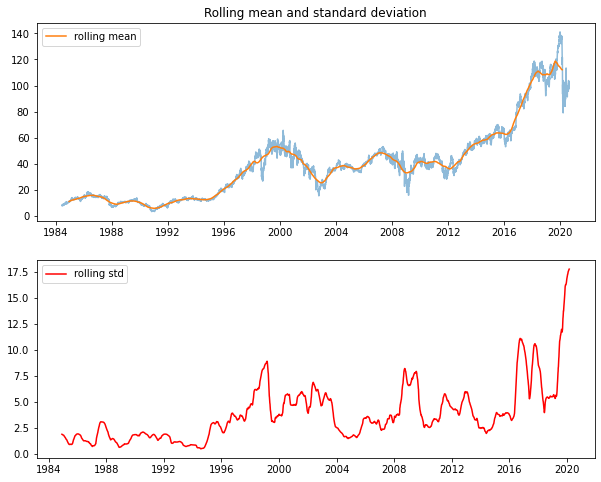

In [7]:
# Compute rolling mean and std
rolling_mean_1year = prices.rolling(260, center=True).mean()
rolling_std_1year = prices.rolling(260, center=True).std()

# Setup plot
fig, axes = plt.subplots(2, figsize=(10, 8))

# Plot rolling mean and std
axes[0].set_title("Rolling mean and standard deviation")
axes[0].plot(prices, alpha=0.5)
axes[0].plot(rolling_mean_1year, label="rolling mean")
axes[0].legend()
axes[1].plot(rolling_std_1year, c="red", label="rolling std")
axes[1].legend()
plt.show()

We can see that pandas computed the mean on each window of data given by the period of 260 business days that we chose.

Note that the series rolling_mean_1year has 130 NaN at the start because for the first 130 business days the rolling window was not entirely filled with data from prices. Similarly there are 129 NaN at the end of the series. The same is true for the series rolling_std_1year.

#### Using rolling windows to detect outliers in time series
For time series we often look for points which deviate from local behavior (local outliers). Below we detect local outliers by using the rolling window to compare a value with its preceding values (center=False) or its surrounding values (center=True). Here we use the rolling mean and rolling standard deviation to create bounds on acceptable values. A value that falls outside these bounds is flagged as an outlier candidate.



In [9]:
def detect_outliers_rolling(timeseries, days=10, n_std=2, center=False):

    rolling_mean = timeseries.rolling(window=days, center=center).mean()
    rolling_std = timeseries.rolling(window=days, center=center).std()
    lower_bound = rolling_mean - (n_std * rolling_std)
    upper_bound = rolling_mean + (n_std * rolling_std)

    # Identify outliers
    mask = (timeseries < lower_bound) | (timeseries > upper_bound)
    outliers = timeseries[mask]

    # Plot bounds and outliers
    plt.figure(figsize=(12, 6))
    plt.plot(timeseries, "lightblue", label="Time series")
    plt.plot(rolling_mean, "orange", label="Rolling mean")
    plt.plot(upper_bound, "r--", label="Bounds", alpha=0.5)
    plt.plot(lower_bound, "r--", label="", alpha=0.5)
    plt.plot(outliers, "ro", markersize=5, label="Outlier candidate")
    plt.legend(loc="best")
    plt.grid(True)
    plt.title(
        "{} outliers detected using a moving window of size = {}".format(
            len(outliers), days
        )
    )
    plt.show()

The time period and the parameter values below were chosen for the purpose of a good plot. Feel free to explore different time periods and parameter values.

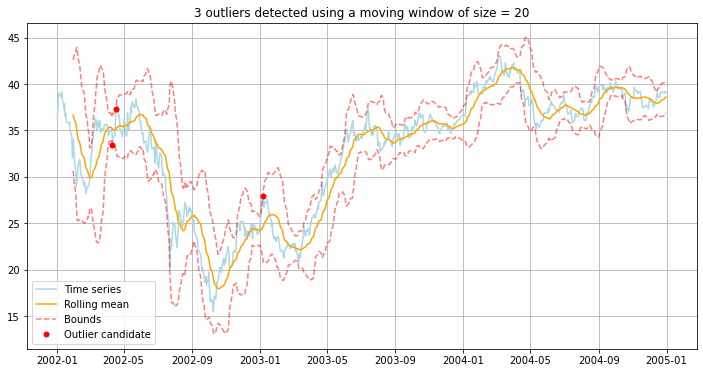

In [10]:
detect_outliers_rolling(prices["2002":"2004"], days=20, n_std=3)

Some final observations:

* Increasing the window size will weaken the change of the current mean and std due to a new timepoint.
* When the curve is moving up or down for a longer period of time then the local standard deviation grows, thus widening the bounds outside which points have to fall in order to get flagged as outliers.
* Setting center=True requires us to use data from the future and thus can only be used to detect outliers in hindsight.
* With center=False we are trying to detect a change in behavior compared to the preceding window. This could indicate the imminent failure of a machine or a novel behavior of consumers.

#### Summary
Let’s summarize what we’ve learned in this unit. Here are a few takeaways:

* Rolling windows are a way to aggregate the data over time
* The choice of the window’s length depends on the frequency of data as well as our objective
* As an example we used rolling windows to detect outliers in the data